# NLP Project

## Download of the Dataset

In [1]:
from utils.seeder import set_random_seed
SEED = 42

set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import os

In [3]:
def get_labels_list(row: pd.Series) -> pd.Series:
    return [index for index, value in row.items() if value == 1]

def get_dataframe(data_folder: str, df_type: str) -> pd.DataFrame:
    assert df_type in ['training', 'validation', 'test', 'validation-zhihu'], 'Specify the `df_type` as either training, validation or test'
    
    arguments_df = pd.read_csv(os.path.join(data_folder, f'arguments-{df_type}.tsv'), sep='\t', header=0)
    labels_df = pd.read_csv(os.path.join(data_folder, f'labels-{df_type}.tsv'), sep='\t', header=0)
    
    arguments_df['Labels'] = labels_df.apply(lambda x: get_labels_list(x), axis=1)
    
    arguments_df.drop('Argument ID', axis=1, inplace=True)
    labels_df.drop('Argument ID', axis=1, inplace=True)
    
    return arguments_df, labels_df

In [4]:
arguments_train_df, labels_train_df = get_dataframe('data', 'training')
arguments_test_df, labels_test_df = get_dataframe('data', 'validation')

In [5]:
print('Arguments dataframe structure:')
arguments_train_df.head()

Arguments dataframe structure:


,Conclusion,Stance,Premise,Labels
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,[Security: societal]
1,We should ban fast food,in favor of,fast food should be banned because it is reall...,[Security: personal]
2,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[Power: dominance, Security: societal]"
3,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[Security: societal, Conformity: rules, Univer..."
4,We should ban factory farming,against,factory farming allows for the production of c...,"[Security: personal, Benevolence: caring, Univ..."


In [6]:
print('Labels dataframe structure:')
labels_train_df.head()

Labels dataframe structure:


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [7]:
print(f'Number of rows of the train dataframe: {len(arguments_train_df)}')
print(f'Number of rows of the test dataframe: {len(arguments_test_df)}')

Number of rows of the train dataframe: 5393
Number of rows of the test dataframe: 1896


In [8]:
from sklearn.model_selection import train_test_split

arguments_train_df, arguments_val_df, labels_train_df, labels_val_df = train_test_split(
    arguments_train_df, labels_train_df, test_size=.33, random_state=SEED)

arguments_train_df.reset_index(drop=True, inplace=True)
labels_train_df.reset_index(drop=True, inplace=True)
arguments_val_df.reset_index(drop=True, inplace=True)
labels_val_df.reset_index(drop=True, inplace=True)

In [9]:
print(f'Number of rows of the train dataframe after splitting: {len(arguments_train_df)}')
print(f'Number of rows of the validation dataframe after splitting: {len(arguments_val_df)}')

Number of rows of the train dataframe after splitting: 3613
Number of rows of the validation dataframe after splitting: 1780


In [10]:
import matplotlib.pyplot as plt 

def plot_stance_distribution(arguments_df: pd.DataFrame, title: str = 'Stance distribution'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    arguments_df.Stance.value_counts().plot(ax=ax, kind='bar')


    # Show just the x grid
    ax.grid(axis='x')

    # set title and axis labels
    plt.suptitle(title)

    ax.set_xlabel('stance')
    ax.set_ylabel('count')

    plt.tight_layout()


    plt.show()

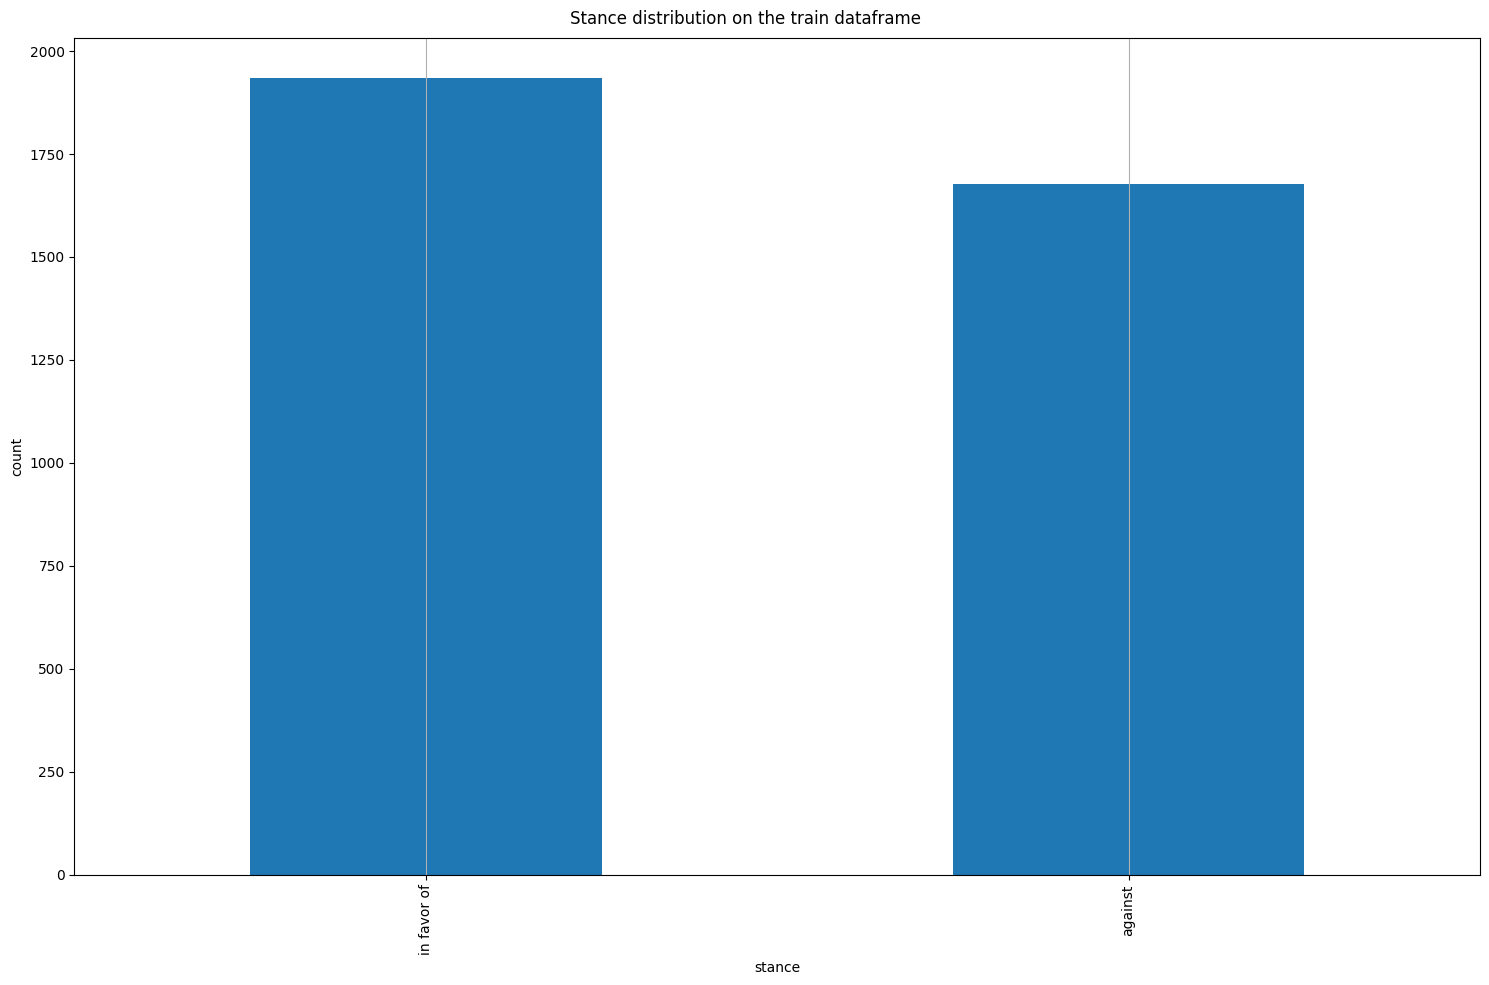

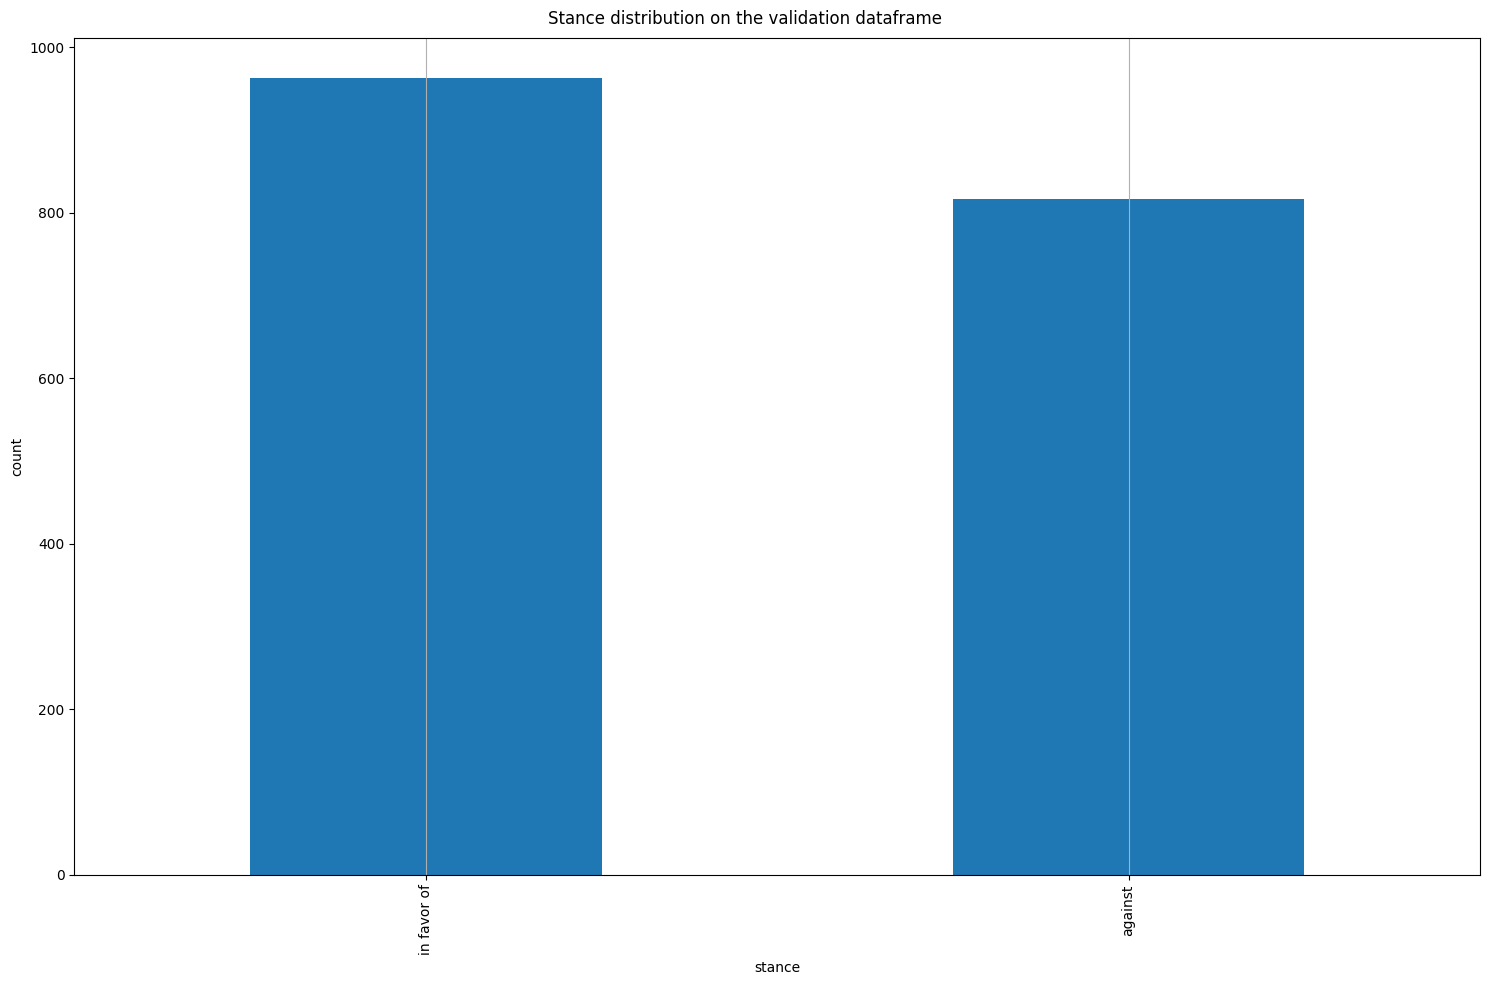

In [11]:
plot_stance_distribution(arguments_train_df, title='Stance distribution on the train dataframe')
plot_stance_distribution(arguments_val_df, title='Stance distribution on the validation dataframe')

In [12]:
import matplotlib.pyplot as plt 

def plot_sentiment_distribution(labels_df: pd.DataFrame, title: str = 'Sentiment values distribution'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    labels_train_df.sum().plot(ax=ax, kind='bar')


    # Show just the x grid
    ax.grid(axis='x')

    # set title and axis labels
    plt.suptitle('Sentiment values distribution')

    ax.set_xlabel('sentiment values')
    ax.set_ylabel('count')

    plt.tight_layout()

    plt.show()

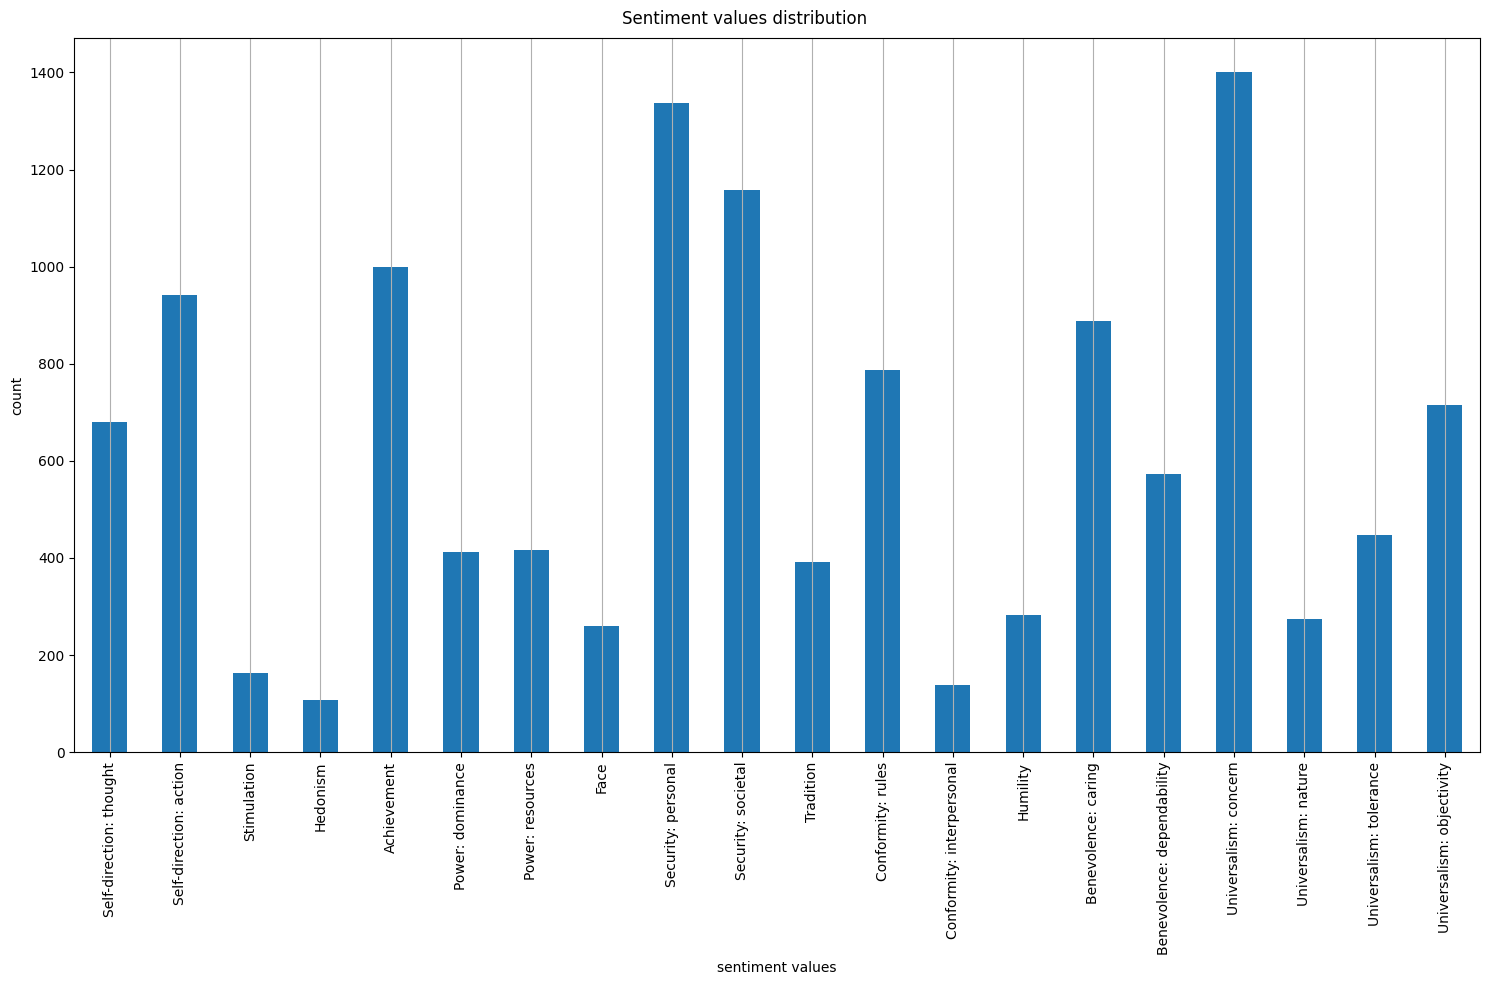

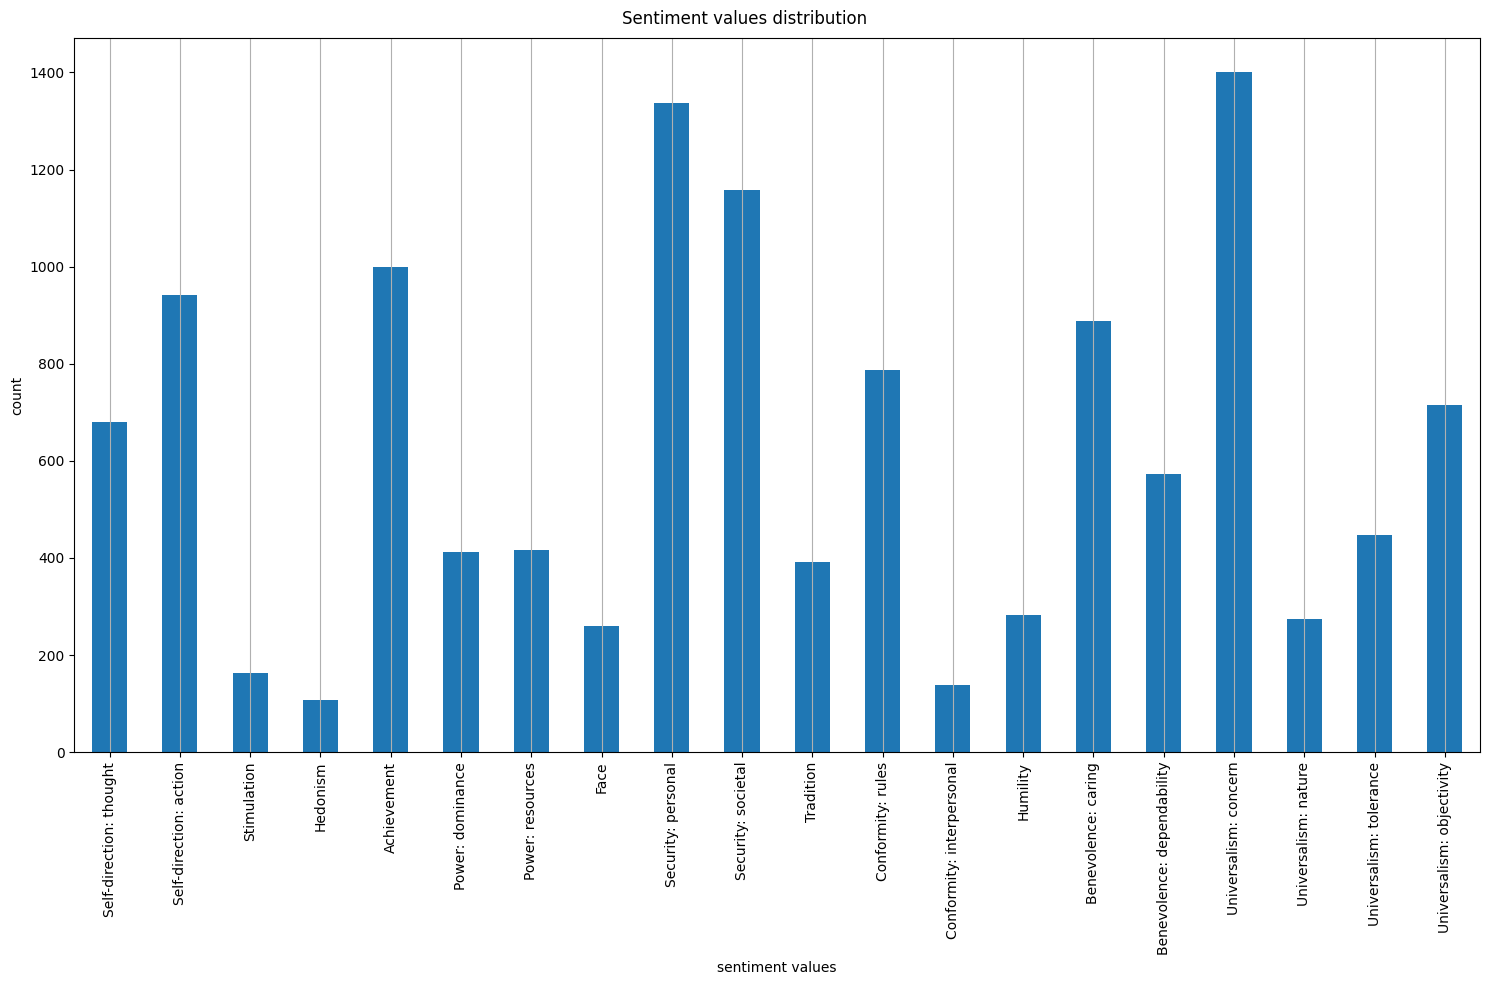

In [13]:
plot_sentiment_distribution(labels_train_df, title='Sentiment values distribution on the train dataframe')
plot_sentiment_distribution(labels_val_df, title='Sentiment values distribution on the validation dataframe')

In [14]:
import numpy as np

def plot_sequence_length_analysis(arguments_df: pd.DataFrame, df_name: str = 'dataset'):
    """Analyse the length of the premises + stances + conclusions
    Parameters
    ----------
    df : DataFrame
        A pandas dataframe.
    """
    # Length of each training sentence
    train_sentences_lenghts = arguments_df.Premise.str.len() + arguments_df.Conclusion.str.len() + 1

    # Histogram of the sentences length distribution
    hist, bin_edges = np.histogram(train_sentences_lenghts, bins=np.max(train_sentences_lenghts) + 1, density=True) 
    # Cumulative distribution of the sentences length
    C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(bin_edges[1:], hist)
    plt.title(f'Distribution of the sentence length across the {df_name}')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(bin_edges[1:], C)
    plt.title(f'Comulative distribution of the sentence length across the {df_name}')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.show()

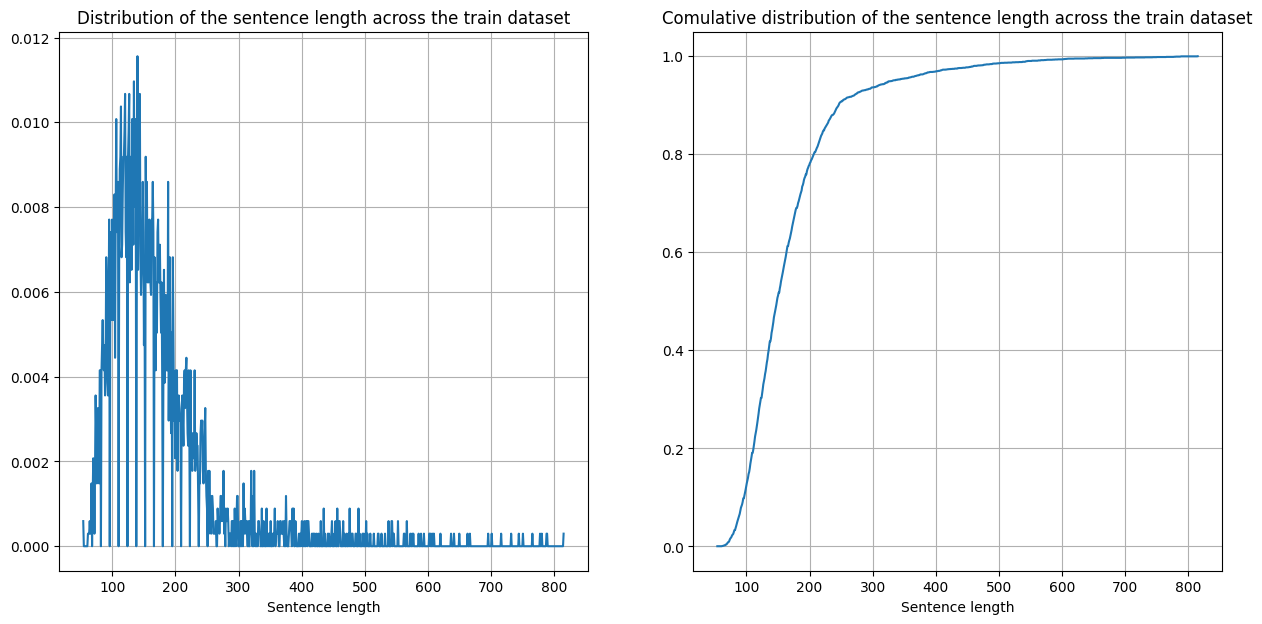

In [15]:
plot_sequence_length_analysis(arguments_train_df, df_name='train dataset')

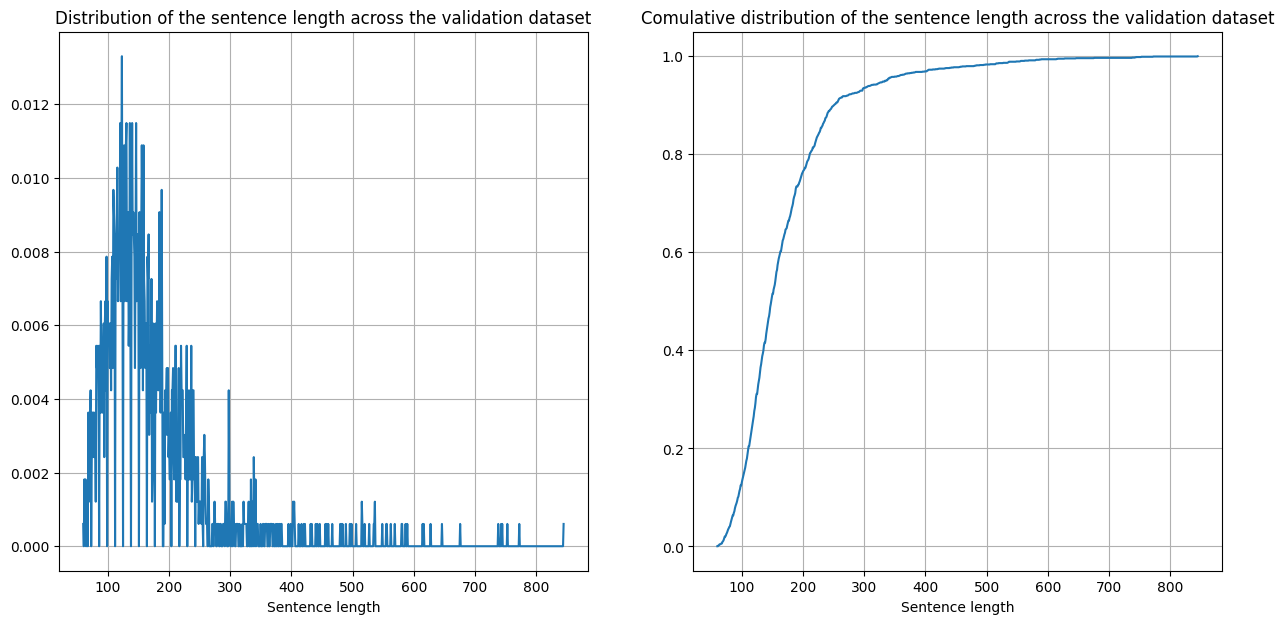

In [16]:
plot_sequence_length_analysis(arguments_val_df, df_name='validation dataset')

In [17]:
quantile_95 = (arguments_train_df.Premise.str.len() + arguments_train_df.Conclusion.str.len() + 1).quantile(.95, interpolation='nearest')

print(f'The 95th quantile of input lengths in the train dataset is: {quantile_95}')

The 95th quantile of input lengths in the train dataset is: 331


In [18]:
total_corpus = arguments_train_df.Conclusion.tolist() + arguments_train_df.Premise.tolist()

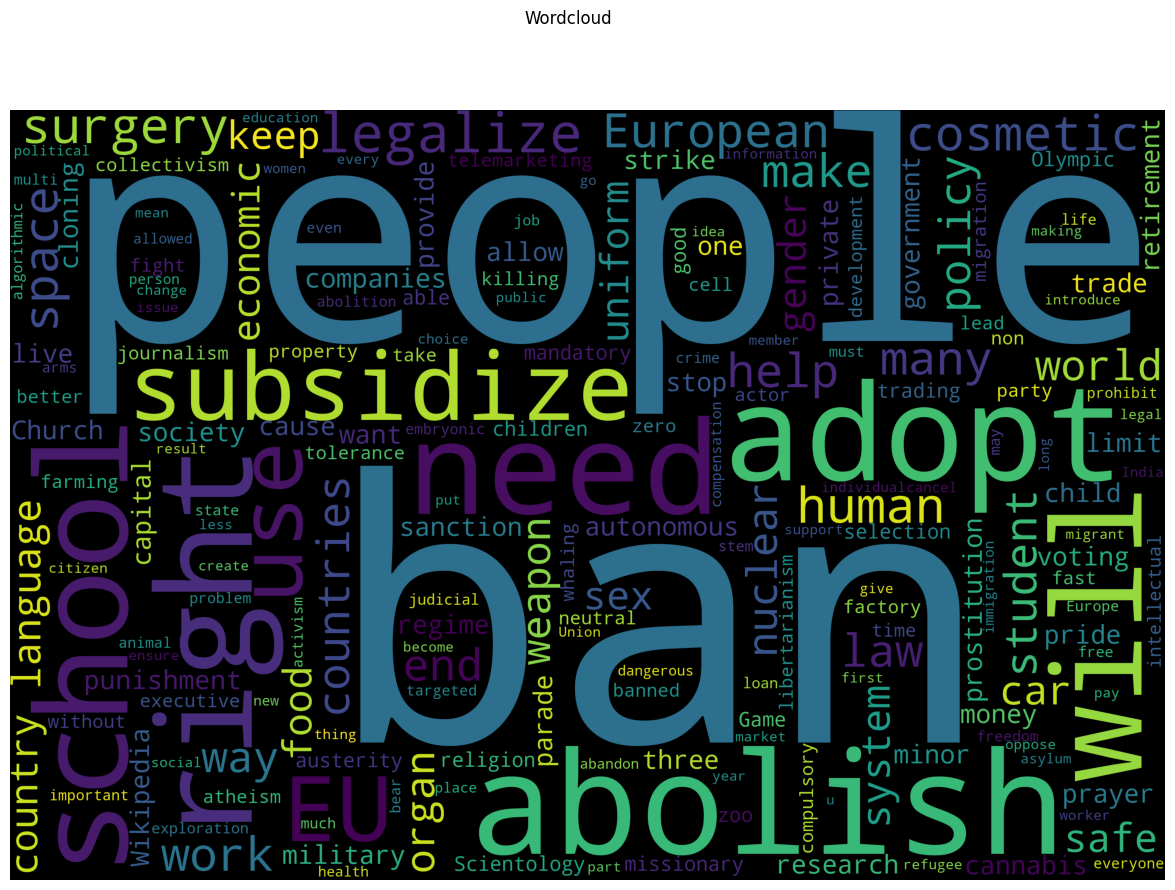

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=3000, height=2000, collocations=False, stopwords=STOPWORDS).generate(' '.join(total_corpus))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud)
plt.suptitle('Wordcloud') 
plt.axis("off")
plt.show()

In [20]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [21]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [22]:
len(labels_train_df.columns.to_list())

20

In [23]:
#label_to_number_dict = {l: i for i, l in enumerate(labels_train_df.columns.to_list()[1:])}
#number_to_label_dict = {i: l for l, i in label_to_number_dict.items()}

In [24]:
#model_name = 'distilbert-base-cased'
model_name = 'distilroberta-base'

In [25]:
from transformers import AutoTokenizer

# Defining some key variables that will be used later on in the training
MAX_LEN = quantile_95
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03
tokenizer = AutoTokenizer.from_pretrained(model_name, problem_type="multi_label_classification")


num_added_toks = tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True) ##This line is updated

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

###The tokenizer has to be saved if it has to be reused
#tokenizer.save_pretrained(<output_dir>)

In [26]:
# Change from dataframe to numpy

class Triage(Dataset):
    def __init__(self, arguments_df: pd.DataFrame, labels_df: pd.DataFrame, tokenizer, max_len):
        self.len = len(arguments_df)
        self.arguments_data = arguments_df
        self.labels_data = labels_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        premise = self.arguments_data.Premise[index]
        conclusion = self.arguments_data.Conclusion[index]
        stance = stance_encoder[self.arguments_data.Stance[index]]
        
        input_text = premise + f' {stance} ' + conclusion
        
        '''inputs = self.tokenizer.encode_plus(
            input_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding=True,
            #return_token_type_ids=False,
            truncation=True
        )'''
        ''' ids = inputs['input_ids']
        mask = inputs['attention_mask']'''
        
        return input_text, self.labels_data.loc[index].to_list()

        '''return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.labels_data.loc[index].to_list(), dtype=torch.long)
        } '''
    
    def __len__(self):
        return self.len

In [27]:
# Creating the dataset and dataloader for the neural network
train_set = Triage(arguments_train_df, labels_train_df, tokenizer, MAX_LEN)
val_set = Triage(arguments_test_df, labels_test_df, tokenizer, MAX_LEN)

In [28]:
def collate_batch(batch):
    input_texts = []
    labels = []
    
    for t, l in batch:
        input_texts.append(t)
        labels.append(l)
    
    inputs = tokenizer(
        input_texts,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding=True,
        truncation=True,
        return_tensors='pt')
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    
    return {
        'ids': ids,
        'mask': mask,
        'labels': torch.tensor(labels, dtype=torch.float32)
    }

dataloader_params = {
    'shuffle': True,
    'num_workers': 0,
    'collate_fn': collate_batch
}

train_params = {**dataloader_params, 'batch_size': TRAIN_BATCH_SIZE}

val_params = {**dataloader_params, 'batch_size': VAL_BATCH_SIZE}


In [29]:
training_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [30]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
'''
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output'''

'\nclass DistillBERTClass(torch.nn.Module):\n    def __init__(self):\n        super(DistillBERTClass, self).__init__()\n        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")\n        self.pre_classifier = torch.nn.Linear(768, 768)\n        self.dropout = torch.nn.Dropout(0.3)\n        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)\n\n    def forward(self, input_ids, attention_mask):\n        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)\n        hidden_state = output_1[0]\n        pooler = hidden_state[:, 0]\n        pooler = self.pre_classifier(pooler)\n        pooler = torch.nn.ReLU()(pooler)\n        pooler = self.dropout(pooler)\n        output = self.classifier(pooler)\n        return output'

In [31]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels_train_df.columns),
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

model.resize_token_embeddings(len(tokenizer))

model.to(device)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [32]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs,  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [34]:

# Creating the loss function and optimizer
#loss_function = torch.nn.BCEWithLogitsLoss()
loss_function = FocalLoss()
optimizer = torch.optim.Adam(params=[
                {'params': model.roberta.parameters(), 'lr': LEARNING_RATE_BASE},
                {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_HEAD}
            ])

In [35]:
# Function to calcuate the accuracy of the model

def calculate_accuracy(out, targets, threshold=.5):
    out = out.sigmoid()
    return ((out > threshold) == targets.bool()).float().mean().item()

In [36]:
from IPython.display import DisplayHandle
import os
import sys
from time import time
from transformers import AutoModelForSequenceClassification
from typing import Optional


def _loss_validate(val_dataloader: DataLoader):
    print()
    # disp = display('', display_id=True)

    # Variables for accumulating the loss1 and loss2
    running_loss = .0
    running_accuracy = .0

    # Number of evaluated samples
    batch_step = 0

    # Starting time
    start_time = time()

    torch.cuda.empty_cache()

    # Iterate over all batches
    for batch_idx, data in enumerate(val_dataloader, 0):
        with torch.no_grad():
            # Update number of evaluated samples
            batch_step += 1
            
            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float32)
        
            # Compute output
            outputs = model(ids, mask)
            
            # Loss
            loss = loss_function(outputs.logits, targets)
            running_loss += loss.item()

            accuracy = calculate_accuracy(outputs.logits, targets)
            running_accuracy += accuracy

        current_time = time() - start_time

        # Print results
        print(
            f'validate {batch_idx + 1}/{len(val_dataloader)}, ' +
            f'{current_time:.0f}s {current_time / (batch_idx + 1) * 1e3:.0f}ms/step, ' +
            f'validation loss: {running_loss / batch_step:.3g}, '
            f'validation accuracy: {running_accuracy * 100 / batch_step:.3g} %' +
            '               ',
            end='\r'
            )

    final_loss = running_loss / batch_step
    final_accuracy = running_accuracy / batch_step
    
    print(
        f'validate: ' +
        f'{current_time:.0f}s {current_time / (batch_idx + 1) * 1e3:.0f}ms/step, ' +
        f'validation loss: {running_loss / batch_step:.3g}, '
        f'validation accuracy: {running_accuracy * 100 / batch_step:.3g} %' +
        '               '
        )

    return final_loss, final_accuracy



def train(train_dataloader: DataLoader, val_dataloader: DataLoader, model: AutoModelForSequenceClassification,
          checkpoint_path: Optional[str] = None, epochs: int = 3, steps_validate: int = 100) -> None:

    # Create path to save checkpoints
    if checkpoint_path is None:
        checkpoint_path = os.path.join('data', 'checkpoints.pth')

    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    # Total steps to perform
    # tot_steps = len(train_dataloader) * epochs
    # Number of step already done
    n_steps = 0
    
    model.train()

    # Iterate across the epochs
    for epoch in range(epochs):
        # Set up display element
        #disp = display('', display_id=True)

        # Remove unused tensors from gpu memory
        torch.cuda.empty_cache()

        # Initialize running losses
        running_loss = 0.0
        running_accuracy = 0.0
        
        optimizer.zero_grad()

        start_time = time()

        # Number of batches for the current update step
        batch_steps=0

        for batch_idx, data in enumerate(train_dataloader, 0):
            # Increment the number of batch steps
            batch_steps += 1

            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float32)
        
            # Compute output
            outputs = model(ids, mask)
            
            # Loss
            loss = loss_function(outputs.logits, targets)
            running_loss += loss.item()

            accuracy = calculate_accuracy(outputs.logits, targets)
            running_accuracy += accuracy

            optimizer.zero_grad()
            #nb_tr_steps += 1
            loss.backward()
            
            # When using GPU
            optimizer.step()

            # Evaluate on validation set
            if batch_idx % steps_validate == steps_validate - 1:
                torch.cuda.empty_cache()
                # Compute both the token importances validation loss and the answer generation validation loss
                val_loss, val_accuracy = _loss_validate(val_dataloader)
                # Update validation loss history
                val_loss_history.append(val_loss)
                val_accuracy_history.append(val_accuracy)
                torch.cuda.empty_cache()

            # Update training history and print                    
            train_loss_history.append(loss.item())
            
            epoch_time = time() - start_time
            batch_time = epoch_time / (batch_idx + 1)
            
            # TODO: function to print batch string
            print(
                f'epoch: {epoch + 1}/{epochs}, ' +
                f'{batch_idx + 1}/{len(train_dataloader)}, '
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step, ' +
                f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
                f'loss: {running_loss / batch_steps:.3g}, ' + 
                f'accuracy: {running_accuracy * 100 / batch_steps:.3g} %' +
                '               ',
                end='\r'
                )

            # Save checkpoint
            '''if steps_save is not None:
                if isinstance(steps_save, float):
                    steps_save=int(steps_save*len(train_dataloader))
                if batch_idx % steps_save == steps_save-1:
                    torch.cuda.empty_cache()

                    checkpoint = {'model_state_dict': model.state_dict(),
                                  'opt_state_dict' : optimizer.state_dict(),
                                  'loss_history': np.array(loss_history),
                                  'val_loss_history': np.array(val_loss_history)}
                    torch.save(checkpoint, checkpoint_path)
                    torch.cuda.empty_cache()''';
        print()
        print(
            f'epoch: {epoch + 1}/{epochs}, ' +
            f'{epoch_time:.0f}s, ' +
            f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
            f'loss: {running_loss / batch_steps:.3g}, ' + 
            f'accuracy: {running_accuracy * 100 / batch_steps:.3g} %'
            )

    # Final checkpoint save
    torch.cuda.empty_cache()

    '''checkpoint = {
        'model_state_dict': model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'loss_history': np.array(loss_history),
        'val_loss_history': np.array(val_loss_history)
        }

    torch.save(checkpoint, checkpoint_path)''';

    # torch.cuda.empty_cache()

In [37]:
train(training_loader, val_loader, model, epochs = 3, steps_validate = 300)

epoch: 1/3, 299/904, 32s 105ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.043, accuracy: 84.1 %                
validate: 10s 22ms/step, validation loss: 0.0369, validation accuracy: 84.8 %                       
epoch: 1/3, 599/904, 70s 117ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0385, accuracy: 84.7 %               
validate: 10s 21ms/step, validation loss: 0.034, validation accuracy: 85.4 %                        
epoch: 1/3, 899/904, 109s 121ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0354, accuracy: 85.2 %               
validate: 10s 22ms/step, validation loss: 0.0332, validation accuracy: 86.2 %                       
epoch: 1/3, 904/904, 120s 132ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0354, accuracy: 85.2 %               
epoch: 1/3, 120s, lr base: 1e-05 lr head: 0.001, loss: 0.0354, accuracy: 85.2 %
epoch: 2/3, 299/904, 28s 94ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0257, accuracy: 87 %                 
validate: 10s 22ms/step, validation loss: 0.03

In [36]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0

    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float32)
       
        outputs = model(ids, mask)
        
        loss = loss_function(outputs.logits, targets)
        tr_loss += loss.item()

        n_correct += calculate_accuracy(outputs.logits, targets)

        nb_tr_steps += 1
        
        if i % 5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct * 100)/nb_tr_steps 
            print(f'Training Loss per 5000 steps: {loss_step}')
            print(f'Training Accuracy per 5000 steps: {accu_step}')

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_steps}')
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_steps
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu}")

    return 
     

In [37]:
for epoch in range(EPOCHS):
    model.train()
    train(epoch)

Training Loss per 5000 steps: 0.16426067054271698
Training Accuracy per 5000 steps: 60.00000238418579
The Total Accuracy for Epoch 0: 85.22953665361995
Training Loss Epoch 0: 0.03525786778057175
Training Accuracy Epoch 0: 85.22953665361995
Training Loss per 5000 steps: 0.041928574442863464
Training Accuracy per 5000 steps: 81.25
The Total Accuracy for Epoch 1: 86.94828661010328
Training Loss Epoch 1: 0.025360991862299648
Training Accuracy Epoch 1: 86.94828661010328
Training Loss per 5000 steps: 0.028529567644000053
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 2: 87.90929326705174
Training Loss Epoch 2: 0.020769197970398997
Training Accuracy Epoch 2: 87.90929326705174


In [38]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            #big_val, big_idx = torch.max(outputs.data, dim=1)
            #n_correct += calcuate_accu(big_idx, targets)
            
            # If no value is over threshold get maximum
            out = outputs.data >= .5
            #indices = out.nonzero()
            
            #big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accuracy(out, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [39]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


NameError: name 'testing_loader' is not defined